# **Geospatial Regular grid model with MODFLOW6**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, glob, warnings
import numpy as np
import geopandas as gpd
import flopy as fp
import shapefile as sf

import folium as flm
from shapely.geometry import Polygon, LineString, Point
from flopy.utils.gridgen import Gridgen
from flopy.mf6.utils.reference import SpatialReference
#import pyvista as pv

from definitions import ROOT_DIR, FLOPY_DIR, FLOPY_EXEC
from utils.flopy_utils import model_map, cells_coordinates 
from utils.io import geodf_map, dataframe_viewer, dict_viewer

#### Set flopy executables directories

In [2]:
work_dir = %pwd
model_name = "geosp_model"
model_files = f"{model_name}_files"
grdg_dir = model_files+'/gridgen'
shp_dir = f'{work_dir}/{model_files}/shp' # for saving generated files (shp, raster, vtk, ...)

In [4]:
os.system(f'rm -fr {model_files}')
my_path = [model_files, grdg_dir, shp_dir]
for x in my_path: 
    if not os.path.exists(x): 
        os.mkdir(x)

# 1. Reading of shapefiles/geopackages

In [68]:
gpkg_dir = f'{ROOT_DIR}/qgis/'#Geopackages'
gpkg_files = glob.glob(f'{gpkg_dir}/*[.gpkg|.shp]',  recursive=True)
gpkg_names = [txt.replace(f'{gpkg_dir}/', '').replace('.gpkg', '') for txt in gpkg_files]
assert gpkg_files # check if files list is not empty
print(gpkg_names)

['/home/yanathan/Projects/Geotherma/qgis/Shapefiles', '/home/yanathan/Projects/Geotherma/qgis/Geopackages', '/home/yanathan/Projects/Geotherma/qgis/Rasters']


In [7]:
gdfs = [gpd.read_file(shp) for shp in gpkg_files[:3]]
gpkg_names = gpkg_names[:3]
geom_type = [list(set(gdf.geometry.geom_type))[0] for gdf in gdfs]

gpkg_dict = {'data':gdfs, 'name':gpkg_names, 'geom_type':geom_type}

In [8]:
for n, x in enumerate(gpkg_dict['data']): 
    for c in x.columns: # erase ' ' at the end of columns names
        x.rename(columns={f'{c}':c.rstrip(' ')}, inplace=True)
        
    print(n, x.columns)

0 Index(['Type', 'Profondeur', 'geometry'], dtype='object')
1 Index(['Année', 'Couche', 'geometry'], dtype='object')
2 Index(['Nom', 'Début ou fin', 'geometry'], dtype='object')


In [9]:
for n in range(3):
    print(gpkg_dict['name'][n])
    dataframe_viewer(gpkg_dict['data'][n])#.sort_values('Type'))

Galeries
Rows : 761, columns : 3


/home/yanathan/.local/share/virtualenvs/Geotherma-DQtWNVFx/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=10, description='rows', max=761, min=10, readout=False), IntSlider(value…

Parties_exploitees
Rows : 850, columns : 3


interactive(children=(IntSlider(value=10, description='rows', max=850, min=10, readout=False), IntSlider(value…

Shaft
Rows : 34, columns : 3


interactive(children=(IntSlider(value=10, description='rows', max=34, min=10, readout=False), IntSlider(value=…

In [10]:
n=0
col = 'Type'
to_find = ['^[b|B]ouv', '[l|L]ien.?$', 'Lien bou', '[v|V]oi.?',]
repl_with = ['Bouveau', 'Lien', 'Lien bouveaux', 'Voie']

for i, x in enumerate(to_find):
    new_val = ''
    qry = gpkg_dict['data'][n].query(f'{col}.str.contains("{x}")')[col]
    if len(set(qry))>1:
        if repl_with is None: 
            print('\nmany values', set(qry))
            new_val = input('uniform with (Enter if no change):')
        else:
            new_val = repl_with[i]
            print(f'\nmany values {set(qry)} have been replaced by : \'{new_val}\'')
        if len(new_val)>0:
            gpkg_dict['data'][n].loc[qry.index, col] = new_val.capitalize()
print('\n--> Results :', set(gpkg_dict['data'][n][col]))


many values {'Bouveau', 'Bouvea', 'Bouveau '} have been replaced by : 'Bouveau'

many values {'Lien', 'lien '} have been replaced by : 'Lien'

many values {'Lien bouveaux', 'Lien bouveau '} have been replaced by : 'Lien bouveaux'

many values {'Voie ', 'Voie'} have been replaced by : 'Voie'

--> Results : {'Bouveau', 'Lien Veines', 'Voie', 'Burquin', 'Lieb', 'Lien bouveaux', 'Recoutelage', 'Lien'}


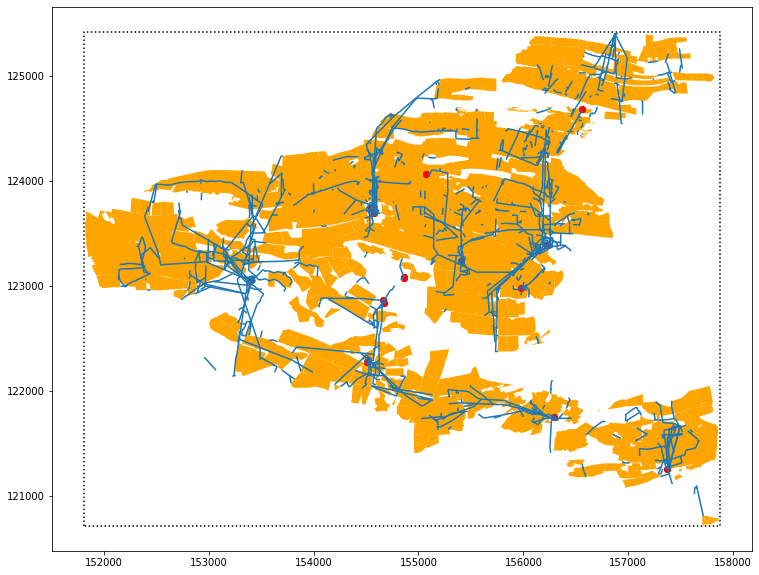

((6066.437133657775, 4711.588183117841),
 [(151809.84956436296, 157876.28669802073),
  (120712.49326382068, 125424.08144693852)])

In [11]:
area_bbox, area_lw = geodf_map(gpkg_dict['data'], plot=True, _return=True, expand=(10, 10), 
                               colors=[None, 'orange', 'red'], figsize=(20,10))
area_lw, area_bbox

* Saving geopackage to shapefile

#### Retrieve each feature ('line', 'point', 'polygon') min/max coordinates

In [12]:
min_max_dict = {} # coordinates min/max per file
ftr_z = {} # keep all rounded Z per file
for n in range(len(gpkg_dict['data'])):
    data = gpkg_dict['data'][n]
    points = []
    for i in data.index:
        ftr = data.geometry[i] # linestring
        cd_txt = ftr.wkt[ftr.wkt.find('('):].strip('()') # coords extraction as string
        for cd in cd_txt.split(', '):
            p = cd.split(' ')
            points.append([float(i) for i in p])

    xmin = np.nanmin([p[0] for p in points])
    ymin = np.nanmin([p[1] for p in points])
    zmin = np.nanmin([p[2] for p in points]) # Z can be negative !!

    xmax = np.nanmax([p[0] for p in points])
    ymax = np.nanmax([p[1] for p in points])
    zmax = np.nanmax([p[2] for p in points])
    
    z = list(set([round(p[2]) for p in points]))
    
    ftr_z.update({gpkg_dict['name'][n]: z})
    min_max_dict.update({gpkg_dict['name'][n]: [(xmin, ymin, min(zmin, zmax)), (xmax, ymax, max(zmin, zmax))]})

In [13]:
dict_viewer(min_max_dict)

Galeries,"[(152137.62264056425, 120804.60895671032, -1070.5), (157716.27208650328, 125414.08144693852, 121.0)]"
Parties_exploitees,"[(151819.84956436296, 120722.49326382068, -1078.3), (157866.28669802073, 125401.77885709287, 144.0)]"
Shaft,"[(153391.94, 121261.4879999999, -1063.4), (157366.95900000018, 124685.816, 155.39)]"


(array([175., 224., 143., 115.,  74.]),
 array([-1070. ,  -831.8,  -593.6,  -355.4,  -117.2,   121. ]),
 <BarContainer object of 5 artists>)

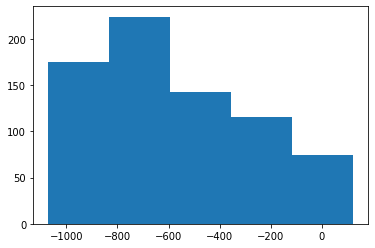

In [14]:
# numerical approach for vertical discretization (not based on geology !)
# Model will contain 5 layers of 247m thick
plt.hist([x for x in ftr_z.values()][0], bins=5) # histogram of Z

# 2. Model building and simulation

## Create MODFLOW6 components for a simulation

#### Create a simulation object (SIM)

In [15]:
sim = fp.mf6.MFSimulation(sim_name=model_name, exe_name=f"{FLOPY_EXEC}/mf6", version="mf6", sim_ws=model_files)

#### Create a temporal discretization object (TDIS)

In [16]:
#simulation of 366 days divided in 12 stress periods of 30 days, each stress period is divided in 3 time steps
#there is a steady state stress period at the beginning of the simulation

nper = 12 # nper = 1 --> if only steady-state simulation
perlen = np.ones(nper)
perlen[0] = 1
perlen[1:] = 30 * 86400 # time unit : second

#Definition of time steps
nstp = np.ones(nper) 
nstp[0] = 1 # first step is steady-state
nstp[1:] = 3

#Definition of stress period type: transient or steady state
periodType = np.zeros(nper, dtype=bool)
periodType[0] = True # steady-sate

#perdata = [(i,int(j),1) for i, j in zip(perlen, nstp)] # for transient
perdata = [(1., 1, 1.)] # for steady-state

In [17]:
tdis = fp.mf6.ModflowTdis(sim, pname="tdis", time_units="seconds", nper=1, perioddata=perdata)

#### Create an iterative model solution object (IMS)

In [18]:
ims = fp.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE", linear_acceleration="BICGSTAB")

#### Create a groundwater flow model object (GWF)

In [19]:
nam_file = f"{model_name}.nam"
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file=nam_file, save_flows=True, 
                           newtonoptions="NEWTON UNDER_RELAXATION",)

## Add internal packages to GWF (internal flow of the system)

#### discretization (DIS) Package

* Model's parameters

In [20]:
dict_viewer(min_max_dict)

Galeries,"[(152137.62264056425, 120804.60895671032, -1070.5), (157716.27208650328, 125414.08144693852, 121.0)]"
Parties_exploitees,"[(151819.84956436296, 120722.49326382068, -1078.3), (157866.28669802073, 125401.77885709287, 144.0)]"
Shaft,"[(153391.94, 121261.4879999999, -1063.4), (157366.95900000018, 124685.816, 155.39)]"


In [21]:
# aquifer geometry (grid) [units in meters]
Nlay = 5 # number of layers 
cw = 50 # cell width
lth = 247 # constant layer thick
aq_th = 1235 # model global thickness
top = 156 # aquifer top
botm = np.arange((top-lth), -aq_th, -lth)   # bottom elevation for each cell/layer
delrow, delcol = np.round((np.array(area_lw)+cw)/cw) # column and row spacing (enlarge models sides with 50 m)
#Nr, Nc = np.round(np.array(area_lw)/[delcol, delrow]) # number of rows and columns (subdivisions)
N = 25 
# aquifer parameters
h0 = 1. # starting water head [ft/s]

In [22]:
dis = fp.mf6.ModflowGwfdis(gwf, nlay=Nlay, nrow=N, ncol=N, delr=delrow, delc=delcol, top=top, botm=botm, 
                           length_units='METERS')

In [23]:
gwf.modelgrid.set_coord_info(xoff=area_bbox[0][0], yoff=area_bbox[1][0], epsg=31370)

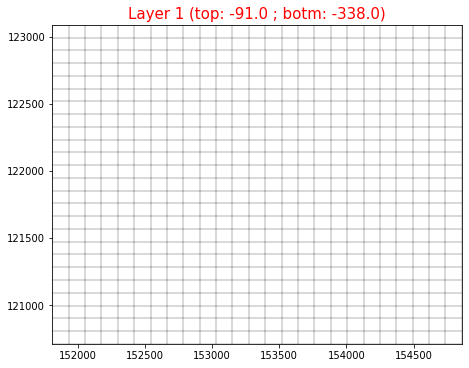

In [24]:
model_map(model=gwf, layer_line=1)

#### initial conditions (IC) Package

In [25]:
start = h0 * np.ones((Nlay, N, N)) # creation of 3D vector filled with h1=100 to represent starting head
#start[:2, 0] = 0.

In [26]:
ic = fp.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

#### node property flow (NPF) Package

In [27]:
icelltype = np.zeros(Nlay)
k = np.ones(Nlay)*.0005 # horizontal hydraulic conductivity [m/s]
k33 = 0.0001
icelltype[0], k[0] = 1, .001
npf = fp.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k, k33=k33) # set cells properties
# icelltype = 1 --> cell is convertible ; 0 --> cell is confined

#### storage (STO) Package

## Retrieve all nodes coordinates like [node, (lrc), (xyz)]

In [28]:
cells_coords = cells_coordinates(gwf)

 The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


In [29]:
cells_coords[:10], f'Total_cells: {len(cells_coords)}'

([[3100, (4, 24, 0), (151870.84956436296, 120759.99326382068, -955.5)],
  [3075, (4, 23, 0), (151870.84956436296, 120854.99326382068, -955.5)],
  [3050, (4, 22, 0), (151870.84956436296, 120949.99326382068, -955.5)],
  [3025, (4, 21, 0), (151870.84956436296, 121044.99326382068, -955.5)],
  [3000, (4, 20, 0), (151870.84956436296, 121139.99326382068, -955.5)],
  [2975, (4, 19, 0), (151870.84956436296, 121234.99326382068, -955.5)],
  [2950, (4, 18, 0), (151870.84956436296, 121329.99326382068, -955.5)],
  [2925, (4, 17, 0), (151870.84956436296, 121424.99326382068, -955.5)],
  [2900, (4, 16, 0), (151870.84956436296, 121519.99326382068, -955.5)],
  [2875, (4, 15, 0), (151870.84956436296, 121614.99326382068, -955.5)]],
 'Total_cells: 3125')

## 2D Intersect model with shapefiles

In [30]:
geodf_map(gpkg_dict['data'], inter_plot=True, colors=[None, 'orange', 'red'], layers_name=gpkg_names)

#### Gridgen object (manipulation of spatial data)

In [31]:
gdg = fp.utils.gridgen.Gridgen(gwf.dis, exe_name=f"{FLOPY_EXEC}/gridgen", model_ws=grdg_dir, 
                               surface_interpolation='replicate')
gdg.build()

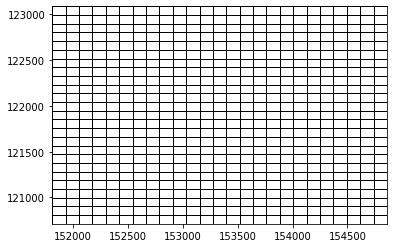

In [32]:
gdg.plot()

In [33]:

for n in range(len(gpkg_dict['geom_type'])):
    gt = gpkg_dict['geom_type'][n].lower()
    if 'point' in gt: gt = 'point'
    elif 'line' in gt: gt = 'line'
    elif 'polygon' in gt: gt = 'polygon'
    else: print(f'Geometry {gt} will not match for intersect process !')
    gpkg_dict['geom_type'][n] = gt

gpkg_dict['geom_type']

['line', 'polygon', 'point']

got an issue with other geometry except 'polygon'

In [34]:
n = 1 # polygon
data, gt = gpkg_dict['data'][n]['geometry'], gpkg_dict['geom_type'][n]
isect_nodes = gdg.intersect(features=list(data), featuretype=gt, layer=0)
isect_nodes[:2]

rec.array([(21,  95,   52.8357,  95), (18, 101, 1909.84  , 101)],
          dtype=[('nodenumber', '<i8'), ('polyid', '<i8'), ('totalarea', '<f8'), ('SHAPEID', '<i8')])

In [35]:
# %%time
cells_sel = [] # select intersected cells
for c in cells_coords:
    for i in isect_nodes:
        if c[0] == i[0] and c not in cells_sel:
            cells_sel.append(c)

In [36]:
annotations = dict(coords=cells_sel, marker=['x', 'r', 5])#, text_fmt=[10, 'b'], annot_type='node')#,  shift=(-100, 100), layer=1)

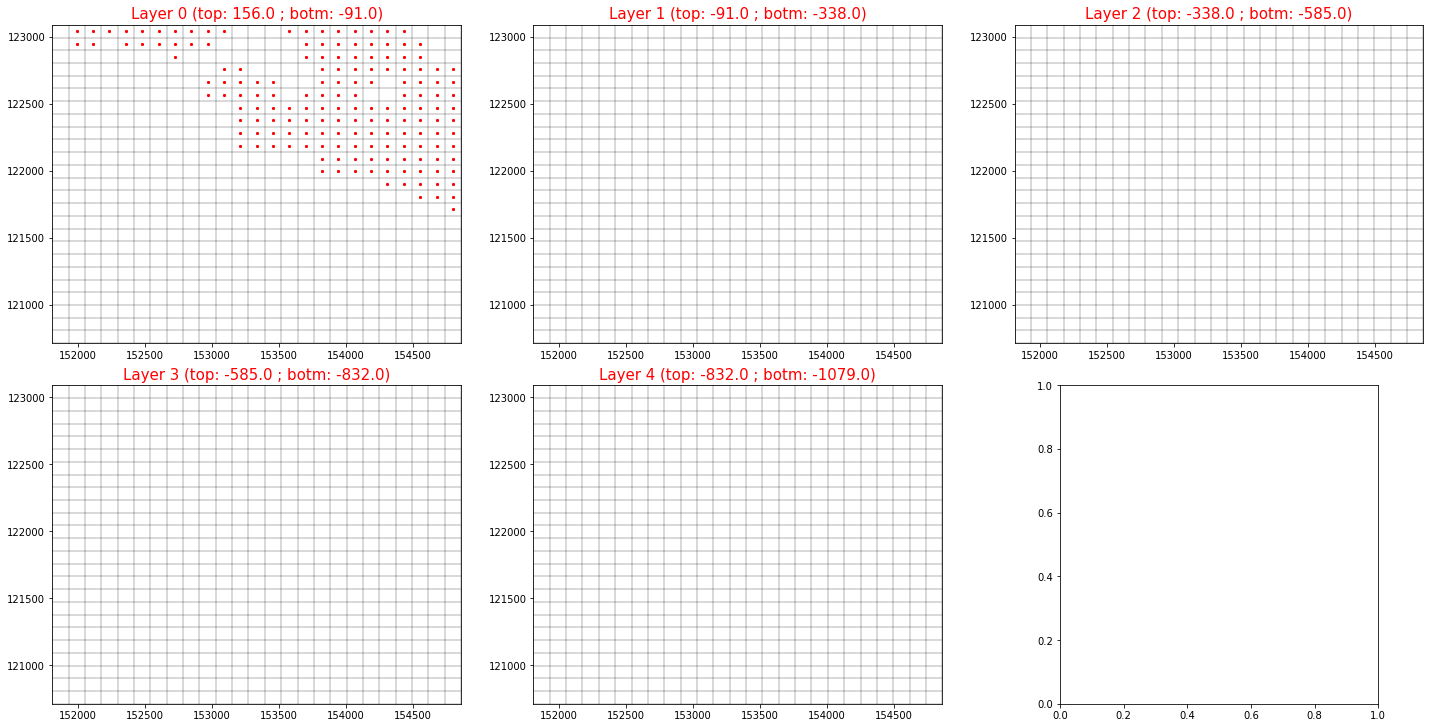

In [37]:
model_map(gwf, annotations=annotations)#, figsize=(15,8), fig_col=1)

## Add stress packages to GWF (external flow into/out the system)

#### recharge (RCH) Package

In [38]:
rch = fp.mf6.ModflowGwfrcha(gwf, recharge=3e-8) # recharge rate [ft/s]

In [39]:
rch.recharge.array.shape

(1, 1, 25, 25)

#### constant head (CHD) Package

In [40]:
cells_sel = [i for i in cells_coords if i[1][0] in [0,1] and i[1][2] in [0]] # select all cells in column 0 for 2 first layers

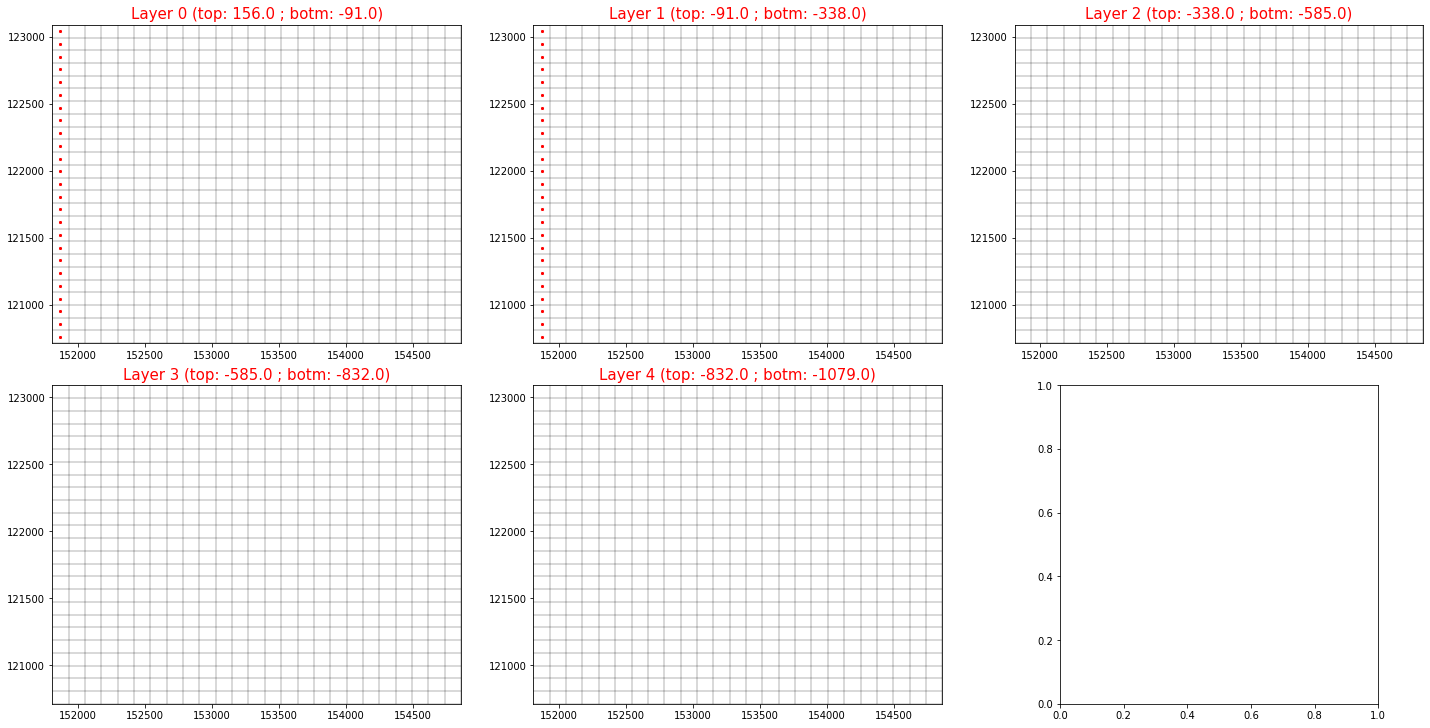

In [41]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations)#, figsize=(15,8), fig_col=1)

In [42]:
# set head to null for selected cells
chd_rec = [(c[1], 0) for c in cells_sel] # ((l,r,c), head)

In [43]:
chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_rec)  # set a constant head stress

In [44]:
# to get a pointer to the recarray (or numpy.recarray) for the first stress period (iper = 0) 
iper = 0 # initial stress period
chd.stress_period_data.get_data(key=iper)

rec.array([((1, 24, 0), 0.), ((1, 23, 0), 0.), ((1, 22, 0), 0.),
           ((1, 21, 0), 0.), ((1, 20, 0), 0.), ((1, 19, 0), 0.),
           ((1, 18, 0), 0.), ((1, 17, 0), 0.), ((1, 16, 0), 0.),
           ((1, 15, 0), 0.), ((1, 14, 0), 0.), ((1, 13, 0), 0.),
           ((1, 12, 0), 0.), ((1, 11, 0), 0.), ((1, 10, 0), 0.),
           ((1, 9, 0), 0.), ((1, 8, 0), 0.), ((1, 7, 0), 0.),
           ((1, 6, 0), 0.), ((1, 5, 0), 0.), ((1, 4, 0), 0.),
           ((1, 3, 0), 0.), ((1, 2, 0), 0.), ((1, 1, 0), 0.),
           ((1, 0, 0), 0.), ((0, 24, 0), 0.), ((0, 23, 0), 0.),
           ((0, 22, 0), 0.), ((0, 21, 0), 0.), ((0, 20, 0), 0.),
           ((0, 19, 0), 0.), ((0, 18, 0), 0.), ((0, 17, 0), 0.),
           ((0, 16, 0), 0.), ((0, 15, 0), 0.), ((0, 14, 0), 0.),
           ((0, 13, 0), 0.), ((0, 12, 0), 0.), ((0, 11, 0), 0.),
           ((0, 10, 0), 0.), ((0, 9, 0), 0.), ((0, 8, 0), 0.),
           ((0, 7, 0), 0.), ((0, 6, 0), 0.), ((0, 5, 0), 0.),
           ((0, 4, 0), 0.), ((0, 3, 0), 

#### drain (DRN) Package

In [45]:
# select cells on row 7 for 1 < column < 8 in first layer
cells_sel = [i for i in cells_coords if i[1][0]==0 and i[1][1]==7 and (i[1][2]>0 and i[1][2]<10)] 

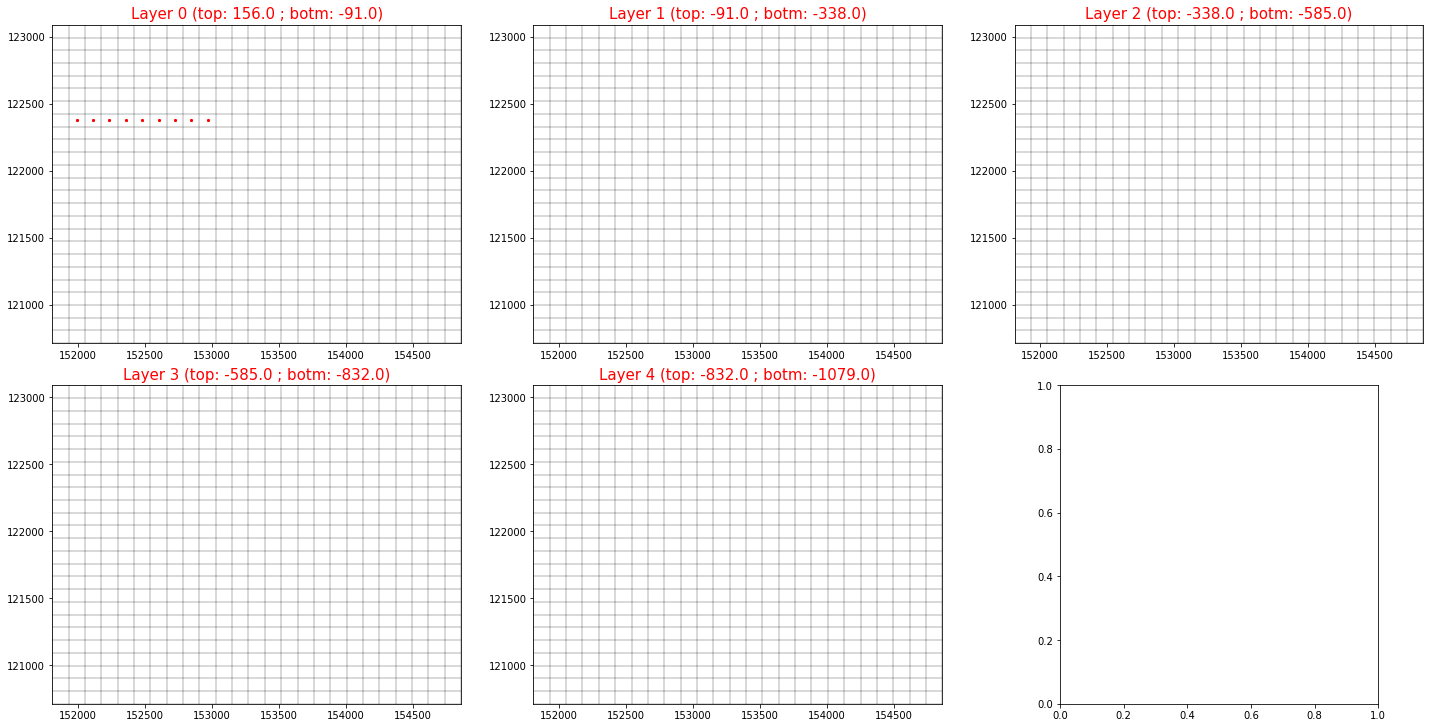

In [46]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations)

In [47]:
drn_rec = []
cond = 1.
elevation = [0, 0, 10, 20, 30, 50, 70, 90, 100]
for c, elv in zip(cells_sel, elevation):
    drn_rec.append((c[1], elv, cond)) # in first layer ((l,r,c), elev, cond)

In [48]:
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_rec)

In [49]:
drn.stress_period_data.array[0]

rec.array([((0, 7, 1),   0., 1.), ((0, 7, 2),   0., 1.),
           ((0, 7, 3),  10., 1.), ((0, 7, 4),  20., 1.),
           ((0, 7, 5),  30., 1.), ((0, 7, 6),  50., 1.),
           ((0, 7, 7),  70., 1.), ((0, 7, 8),  90., 1.),
           ((0, 7, 9), 100., 1.)],
          dtype=[('cellid', 'O'), ('elev', '<f8'), ('cond', '<f8')])

#### well (WEL) Package

In [50]:
cells_sel1 = [i for i in cells_coords if i[1][0]==0 and i[1][1] in [9,11,13] and i[1][2] in [8,10,12,14]] # layer 1
cells_sel2 = [i for i in cells_coords if i[1][0]==1 and i[1][1] in [4,6] and i[1][2] in [6,12]] # layer 2
cells_sel3 = [i for i in cells_coords if i[1][0]==2 and i[1][1] in [5] and i[1][2] in [11]] # layer 3
cells_sel = cells_sel1 + cells_sel2 + cells_sel3

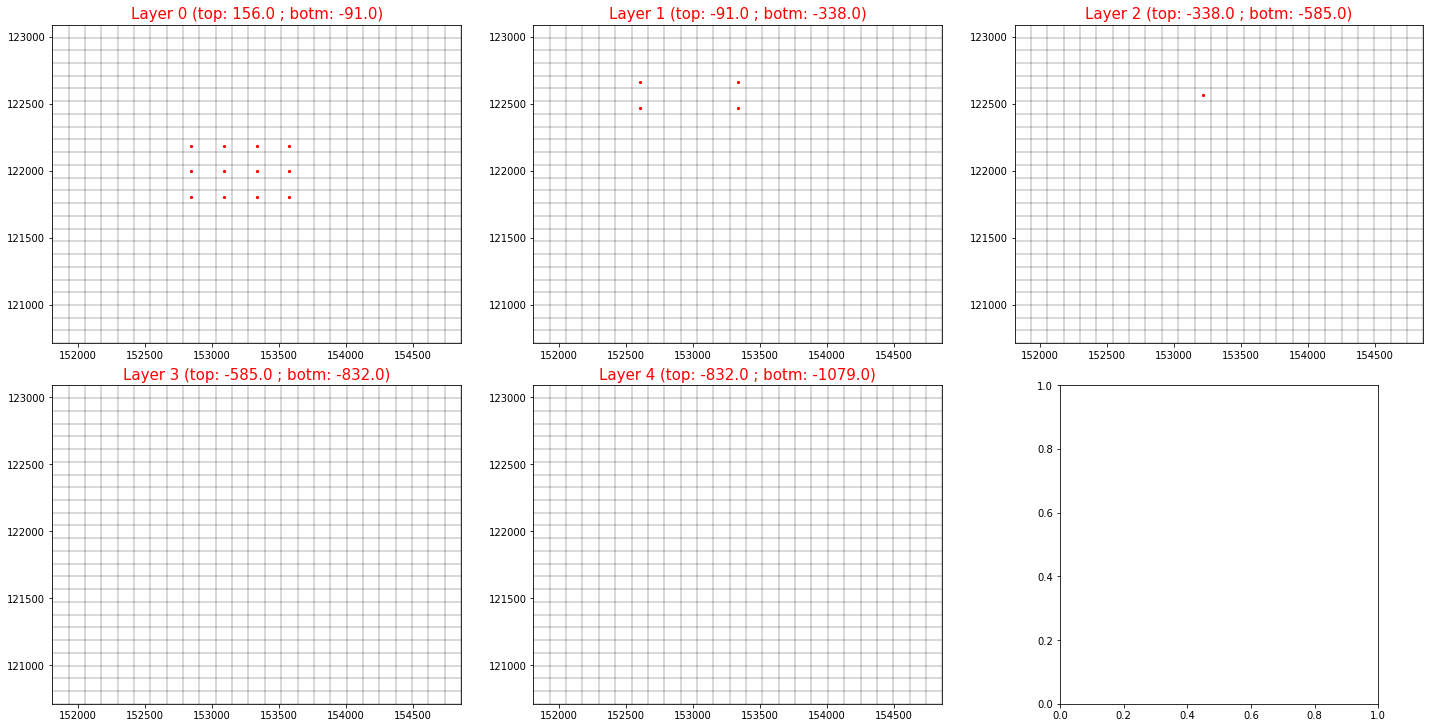

In [51]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations)

### <font color=red>Get a simulation error when adding wells</font>

#### output control (OC) Package

In [52]:
# Save heads and budget output to binary files and print heads to the model listing file at the end of the stress period.
headfile = f"{model_name}.hds" # head information
head_filerecord = [headfile]
budgetfile = f"{model_name}.cbb" # flow terms are written here
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

oc = fp.mf6.ModflowGwfoc(gwf, saverecord=saverecord, head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord, printrecord=printrecord)

## Create the MODFLOW 6 Input Files and Run the Model

### Write the datasets

In [53]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model geosp_model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 50 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 9 based on size of stress_period_data
    writing package oc...


### Run the simulation

In [54]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: /home/yanathan/Projects/Geotherma/flopy/modules_executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided o

## Display results

#### Post-process head results

In [55]:
head = gwf.output.head().get_data(kstpkper=(0, 0)) # kstpkper --> k time step, k stress period

#### Map of layers 

In [56]:
kwargs = {'cnt_fmt':'%2.3f', 'cnt_label':10, 'figsize':(20, 5), 'cb_shrink':0.5, 'cmap':'gist_ncar'}

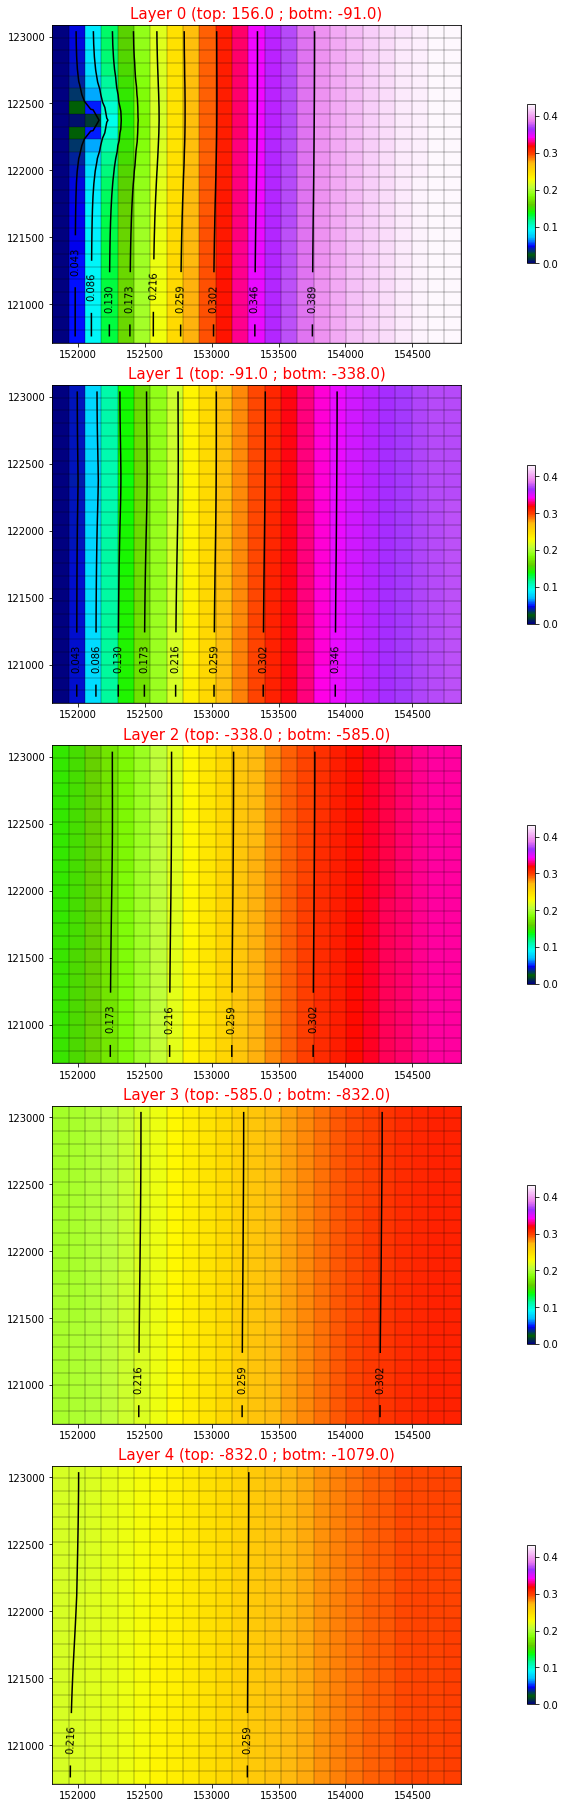

In [57]:
model_map(model=gwf, plot_array=head, layer_line=None, plot_type='map', fig_col=1, **kwargs)

#### Cross-section of heads along rows

Show only row cross-sections stepped by 6 !


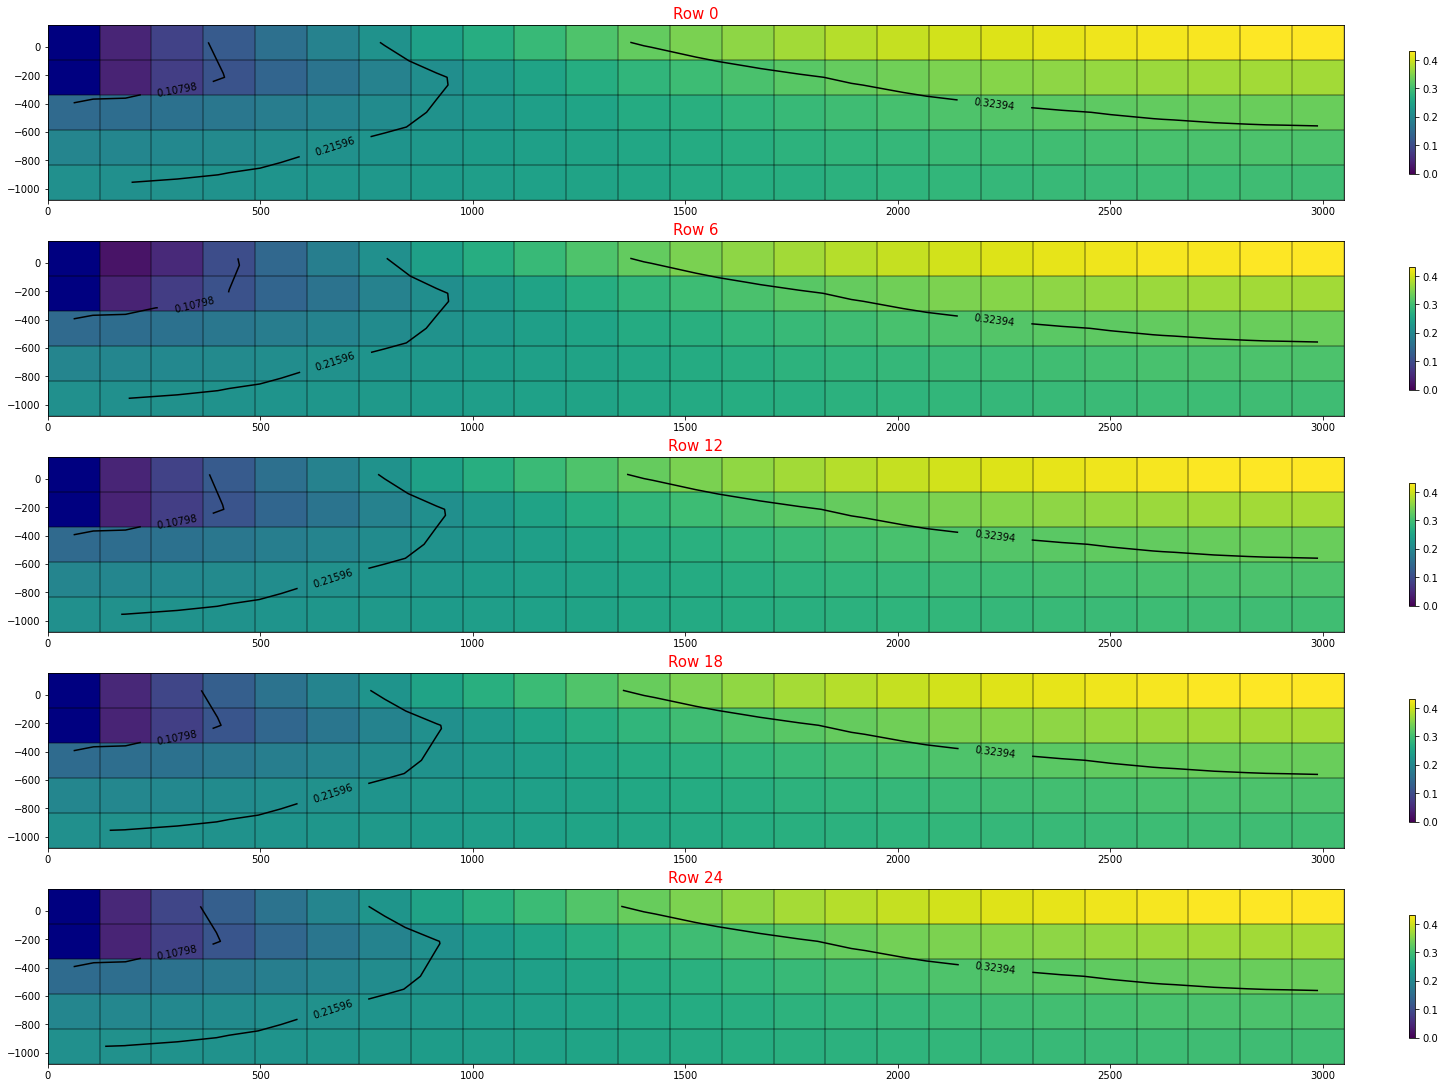

In [58]:
ll = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=ll, plot_type='row', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'n_cnt':4, 'cnt_label':10, 'cnt_color':'k'})# 'cnt_intervals':np.arange(-1, 1, .1)})

#### Cross-section of heads along columns

Show only column cross-sections stepped by 6 !


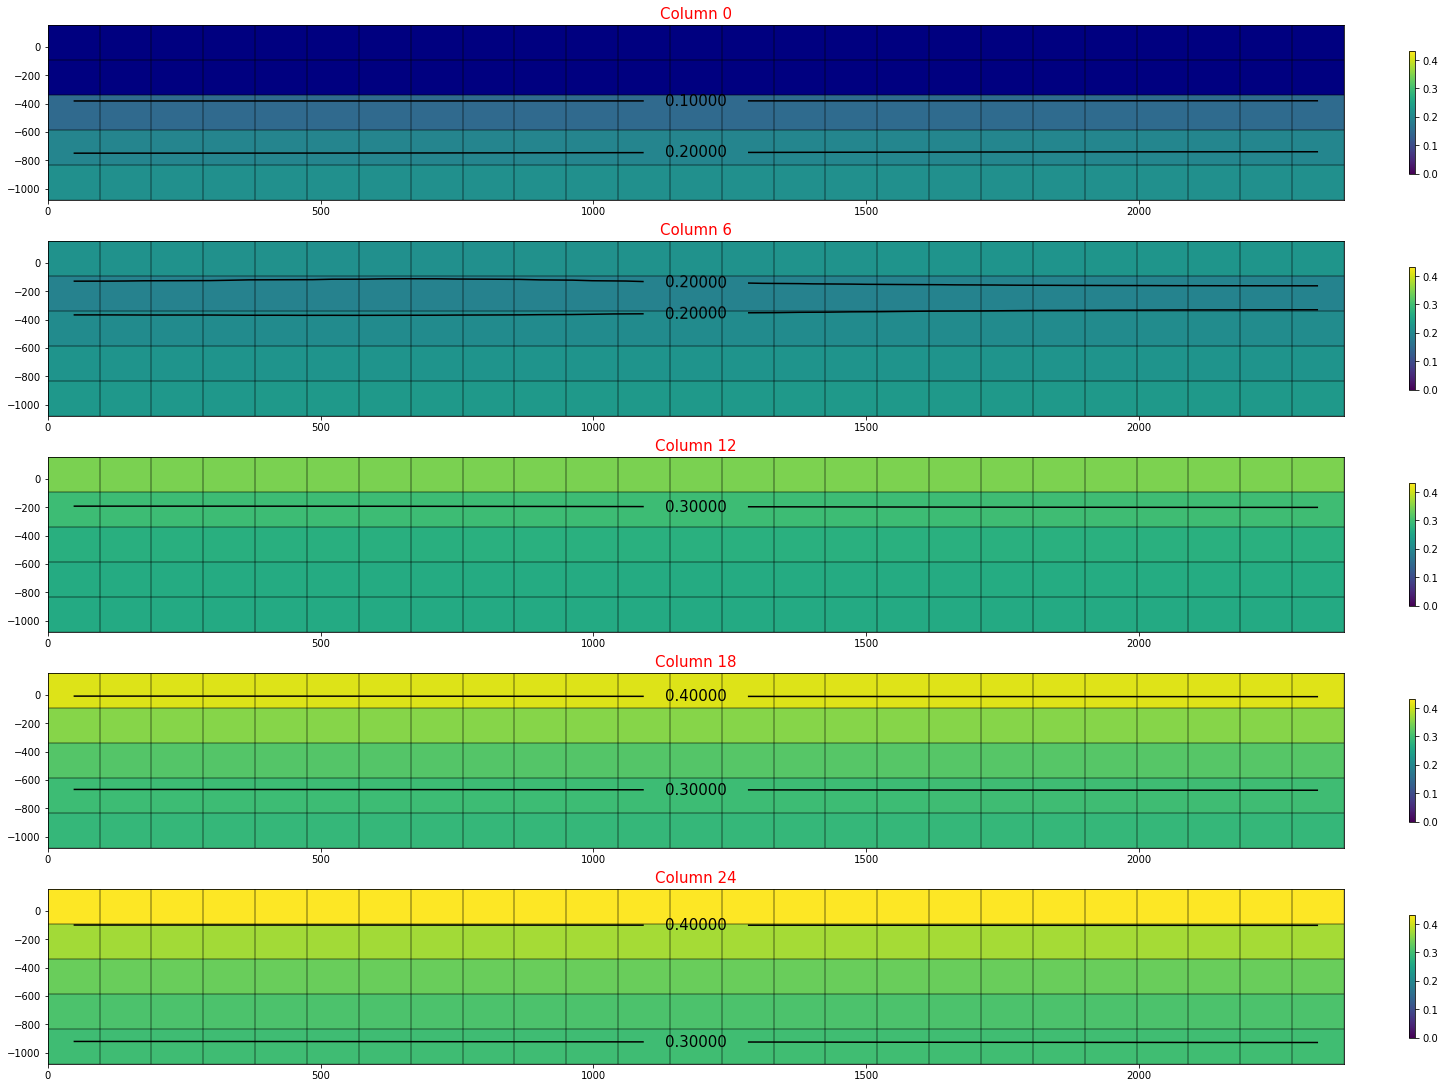

In [59]:
ll = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=ll, plot_type='column', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'cnt_label':15, 'cnt_intervals':np.arange(0, .5, .1)})

## Determine the Flow Residual

In [60]:
flowja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[0]

In [61]:
grb_file = f"{model_name}.dis.grb"
residual = fp.mf6.utils.get_residuals(flowja, grb_file=model_files +'/'+ grb_file)

#### Map of the flow error in Layer 10

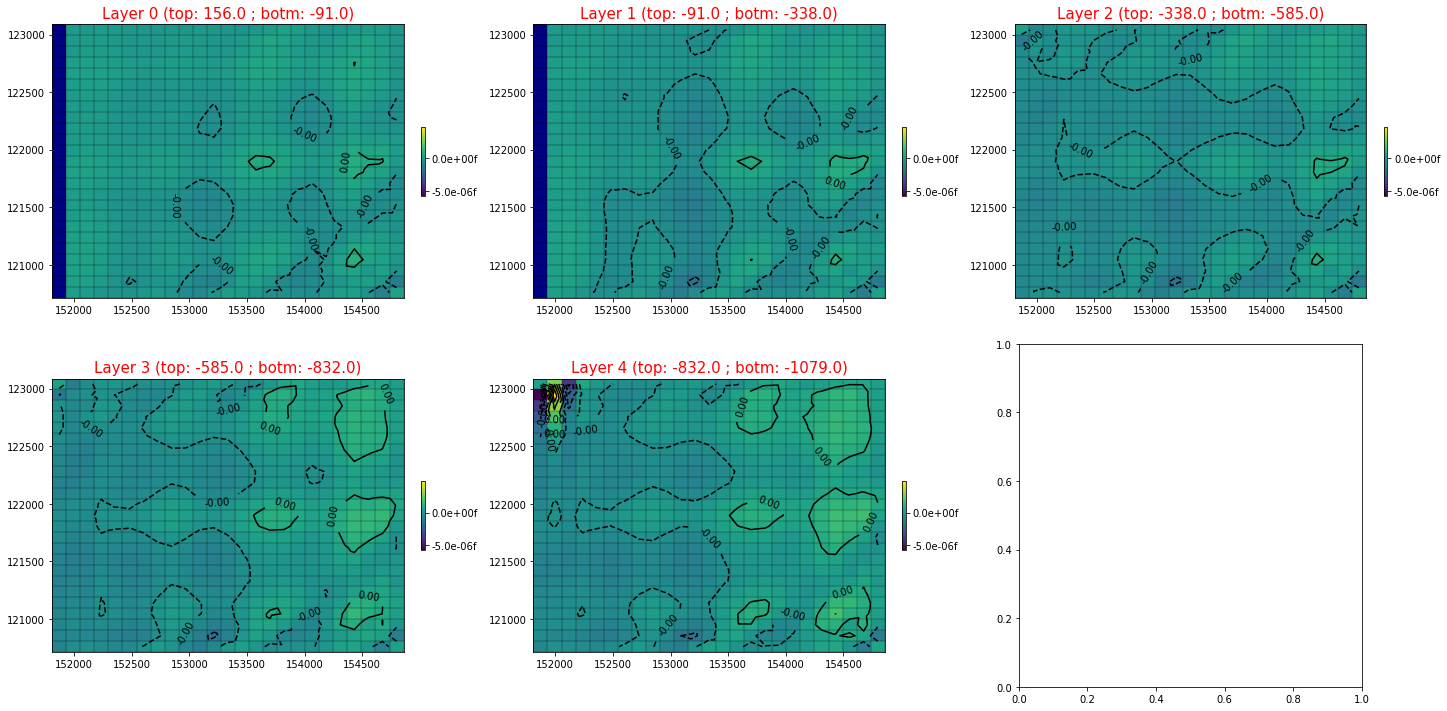

In [62]:
model_map(model=gwf, plot_array=residual, layer_line=None, 
            **{'figsize':(20,5), 'cnt_fmt':"%.2f", 'cb_fmt':'%.1ef', 'cb_shrink':0.2})